In [1]:
using Random
using LinearAlgebra
using PyPlot
using Distributed

function generate_matrix(l::Int, r::Int, n::Int)    
    return rand(n, n) .* (r - l) .+ l
end

addprocs(7)

7-element Vector{Int64}:
 2
 3
 4
 5
 6
 7
 8

In [2]:
@everywhere function naive_matrix_multiply(A, B)
    A = copy(A)
    B = copy(B)
    n, m = size(A)
    m2, p = size(B)

    if m != m2
        print("Невозможно перемножить матрицы из-за их размерностей")
    end

    C = zeros(n, p)
    for i in 1:n
        for j in 1:p
            for k in 1:m
                C[i, j] += A[i, k] * B[k, j]
            end
        end
    end

    return C
end

A = [1 2 3 4; 5 6 7 8; 9 10 11 12; 13 14 15 16]
B = [1 2 3 4; 5 6 7 8; 9 10 11 12; 13 14 15 16]

C = naive_matrix_multiply(A, B)
println(C)

[90.0 100.0 110.0 120.0; 202.0 228.0 254.0 280.0; 314.0 356.0 398.0 440.0; 426.0 484.0 542.0 600.0]


In [3]:
function vinograd(A, B)
    m, n = size(A)
    n2, p = size(B)

    if n != n2
        print("Невозможно перемножить матрицы из-за их размерностей")
    end
    
    C = zeros(Float64, m, p)
    row_factors = zeros(Float64, m)
    col_factors = zeros(Float64, p)
    
    for i in 1:m
        row_factors[i] = sum(A[i, 2k-1] * A[i, 2k] for k in 1:div(n, 2))
    end

    for j in 1:p
        col_factors[j] = sum(B[2k-1, j] * B[2k, j] for k in 1:div(n, 2))
    end

    for i in 1:m
        for j in 1:p
            s = -row_factors[i] - col_factors[j]
            C[i, j] = s + sum((A[i, 2k-1] + B[2k, j]) * (A[i, 2k] + B[2k-1, j]) for k in 1:div(n, 2))
        end
    end

    return C
end

# Пример использования:
A = [1 2 3 4; 5 6 7 8; 9 10 11 12; 13 14 15 16]
B = [1 2 3 4; 5 6 7 8; 9 10 11 12; 13 14 15 16]
C = vinograd(A, B)

println(C) 

function strassen_vinograd_main(A,B)
    # if size(A, 1) > 64
    #     return strassen(A,B,64)
    # end

    return strassen_vinograd(A,B,64)
end

@everywhere function strassen_vinograd(A, B, bound)
    n = size(A, 1)
    if n <= bound
        return naive_matrix_multiply(A,B)  # Простое умножение для малых матриц
    end

    mid = n ÷ 2

    # Разделение матриц на подматрицы
    A11 = A[1:mid, 1:mid]
    A12 = A[1:mid, mid + 1:end]
    A21 = A[mid + 1:end, 1:mid]
    A22 = A[mid + 1:end, mid + 1:end]
    
    B11 = B[1:mid, 1:mid]
    B12 = B[1:mid, mid + 1:end]
    B21 = B[mid + 1:end, 1:mid]
    B22 = B[mid + 1:end, mid + 1:end]

    S1=A21+A22
    S2=S1-A11
    S3=A11-A21
    S4=A12-S2
    S5=B12-B11
    S6=B22-S5
    S7=B22-B12
    S8=S6-B21
    # Умножения
    M1 = strassen_vinograd(S2, S6,bound)
    M2 = strassen_vinograd(A11, B11,bound)
    M3 = strassen_vinograd(A12, B21,bound)
    M4 = strassen_vinograd(S3, S7,bound)
    M5 = strassen_vinograd(S1, S5,bound)
    M6 = strassen_vinograd(S4, B22,bound)
    M7 = strassen_vinograd(A22, S8,bound)

    M1 = fetch(M1)
    M2 = fetch(M2)
    M3 = fetch(M3)
    M4 = fetch(M4)
    M5 = fetch(M5)
    M6 = fetch(M6)
    M7 = fetch(M7)

    # Сборка результирующей матрицы
    T1=M1+M2
    T2=T1+M4
    C11 = M2 + M3
    C12 = T1 + M5 + M6
    C21 = T2-M7
    C22 = T2+M5

    # Объединяем подматрицы в одну матрицу
    C = zeros(n, n)
    C[1:mid, 1:mid] = C11
    C[1:mid, mid+1:end] = C12
    C[mid+1:end, 1:mid] = C21
    C[mid+1:end, mid+1:end] = C22

    return C
end

A = [1 2 3 4; 5 6 7 8; 9 10 11 12; 13 14 15 16]
B = [1 2 3 4; 5 6 7 8; 9 10 11 12; 13 14 15 16]

C = strassen_vinograd(A, B, 64)
println(C)

[90.0 100.0 110.0 120.0; 202.0 228.0 254.0 280.0; 314.0 356.0 398.0 440.0; 426.0 484.0 542.0 600.0]
[90.0 100.0 110.0 120.0; 202.0 228.0 254.0 280.0; 314.0 356.0 398.0 440.0; 426.0 484.0 542.0 600.0]


In [4]:
function strassen_main(A,B)
    # if size(A, 1) > 64
    #     return strassen(A,B,64)
    # end

    return strassen(A,B,64)
end

@everywhere function strassen(A, B, bound)
    A = copy(A)
    B = copy(B)
    n = size(A, 1)

    if n <= bound
        return naive_matrix_multiply(A,B)
    end    
    
    mid = div(n, 2)
    A11 = A[1:mid, 1:mid]
    A12 = A[1:mid, mid+1:end]
    A21 = A[mid+1:end, 1:mid]
    A22 = A[mid+1:end, mid+1:end]

    B11 = B[1:mid, 1:mid]
    B12 = B[1:mid, mid+1:end]
    B21 = B[mid+1:end, 1:mid]
    B22 = B[mid+1:end, mid+1:end]

    P1 = strassen(A11 + A22, B11 + B22, bound)
    P2 = strassen(A21 + A22, B11, bound)
    P3 = strassen(A11, B12 - B22, bound)
    P4 = strassen(A22, B21 - B11,bound)
    P5 = strassen(A11 + A12, B22,bound)
    P6 = strassen(A21 - A11, B11 + B12,bound)
    P7 = strassen(A12 - A22, B21 + B22,bound)

    C11 = P1 + P4 - P5 + P7
    C12 = P3 + P5
    C21 = P2 + P4
    C22 = P1 - P2 + P3 + P6

    # Собираем окончательную матрицу результата
    C = zeros(n, n)
    C[1:mid, 1:mid] = C11
    C[1:mid, mid+1:end] = C12
    C[mid+1:end, 1:mid] = C21
    C[mid+1:end, mid+1:end] = C22

    return C
end

A = [1 2 3 4; 5 6 7 8; 9 10 11 12; 13 14 15 16]
B = [1 2 3 4; 5 6 7 8; 9 10 11 12; 13 14 15 16]

C = strassen(A, B, true)
println(C)

[90.0 100.0 110.0 120.0; 202.0 228.0 254.0 280.0; 314.0 356.0 398.0 440.0; 426.0 484.0 542.0 600.0]


In [5]:

function strassen_main_multi(A,B)
    # if size(A, 1) > 64
    #     return strassen(A,B,64)
    # end

    return strassen_multi(A,B,64)
end

@everywhere function strassen_multi(A, B, bound)
    A = copy(A)
    B = copy(B)
    n = size(A, 1)

    if n <= bound
        return naive_matrix_multiply(A,B)
    end    
    
    mid = div(n, 2)
    A11 = A[1:mid, 1:mid]
    A12 = A[1:mid, mid+1:end]
    A21 = A[mid+1:end, 1:mid]
    A22 = A[mid+1:end, mid+1:end]

    B11 = B[1:mid, 1:mid]
    B12 = B[1:mid, mid+1:end]
    B21 = B[mid+1:end, 1:mid]
    B22 = B[mid+1:end, mid+1:end]

    P1 = @spawn strassen(A11 + A22, B11 + B22, bound)
    P2 = @spawn strassen(A21 + A22, B11, bound)
    P3 = @spawn strassen(A11, B12 - B22, bound)
    P4 = @spawn strassen(A22, B21 - B11,bound)
    P5 = @spawn strassen(A11 + A12, B22,bound)
    P6 = @spawn strassen(A21 - A11, B11 + B12,bound)
    P7 = @spawn strassen(A12 - A22, B21 + B22,bound)

    P1 = fetch(P1)
    P2 = fetch(P2)
    P3 = fetch(P3)
    P4 = fetch(P4)
    P5 = fetch(P5)
    P6 = fetch(P6)
    P7 = fetch(P7)

    C11 = P1 + P4 - P5 + P7
    C12 = P3 + P5
    C21 = P2 + P4
    C22 = P1 - P2 + P3 + P6

    # Собираем окончательную матрицу результата
    C = zeros(n, n)
    C[1:mid, 1:mid] = C11
    C[1:mid, mid+1:end] = C12
    C[mid+1:end, 1:mid] = C21
    C[mid+1:end, mid+1:end] = C22

    return C
end

A = [1 2 3 4; 5 6 7 8; 9 10 11 12; 13 14 15 16]
B = [1 2 3 4; 5 6 7 8; 9 10 11 12; 13 14 15 16]

C = strassen_main_multi(A, B)
println(C)

[90.0 100.0 110.0 120.0; 202.0 228.0 254.0 280.0; 314.0 356.0 398.0 440.0; 426.0 484.0 542.0 600.0]


In [6]:
function strassen_vinograd_main_multi(A,B)
    # if size(A, 1) > 64
    #     return strassen(A,B,64)
    # end

    return strassen_vinograd_multi(A,B,64)
end

function strassen_vinograd_multi(A, B, bound)
    n = size(A, 1)
    if n <= bound
        return naive_matrix_multiply(A,B)  # Простое умножение для малых матриц
    end

    mid = n ÷ 2

    # Разделение матриц на подматрицы
    A11 = A[1:mid, 1:mid]
    A12 = A[1:mid, mid + 1:end]
    A21 = A[mid + 1:end, 1:mid]
    A22 = A[mid + 1:end, mid + 1:end]
    
    B11 = B[1:mid, 1:mid]
    B12 = B[1:mid, mid + 1:end]
    B21 = B[mid + 1:end, 1:mid]
    B22 = B[mid + 1:end, mid + 1:end]

    S1=A21+A22
    S2=S1-A11
    S3=A11-A21
    S4=A12-S2
    S5=B12-B11
    S6=B22-S5
    S7=B22-B12
    S8=S6-B21

    # Умножения
    M1 = @spawn strassen_vinograd(S2, S6,bound)
    M2 = @spawn strassen_vinograd(A11, B11,bound)
    M3 = @spawn strassen_vinograd(A12, B21,bound)
    M4 = @spawn strassen_vinograd(S3, S7,bound)
    M5 = @spawn strassen_vinograd(S1, S5,bound)
    M6 = @spawn strassen_vinograd(S4, B22,bound)
    M7 = @spawn strassen_vinograd(A22, S8,bound)

    M1 = fetch(M1)
    M2 = fetch(M2)
    M3 = fetch(M3)
    M4 = fetch(M4)
    M5 = fetch(M5)
    M6 = fetch(M6)
    M7 = fetch(M7)

    # Сборка результирующей матрицы
    T1=M1+M2
    T2=T1+M4
    C11 = M2 + M3
    C12 = T1 + M5 + M6
    C21 = T2-M7
    C22 = T2+M5

    # Объединяем подматрицы в одну матрицу
    C = zeros(n, n)
    C[1:mid, 1:mid] = C11
    C[1:mid, mid+1:end] = C12
    C[mid+1:end, 1:mid] = C21
    C[mid+1:end, mid+1:end] = C22

    return C
end

A = [1 2 3 4; 5 6 7 8; 9 10 11 12; 13 14 15 16]
B = [1 2 3 4; 5 6 7 8; 9 10 11 12; 13 14 15 16]

C = strassen_vinograd_main_multi(A, B)
println(C)

[90.0 100.0 110.0 120.0; 202.0 228.0 254.0 280.0; 314.0 356.0 398.0 440.0; 426.0 484.0 542.0 600.0]


2
4
8
16
32
64
128
256
512
1024


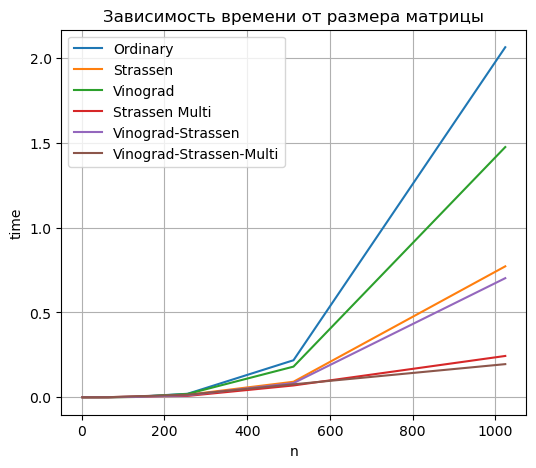

In [25]:
n = [2^i for i in 1:10]
time1 = Float64[]
time2 = Float64[]
time3 = Float64[]
time4 = Float64[]
time5 = Float64[]
time6 = Float64[]

strassen_bound = false

for dim in n
    println(dim)
    A = generate_matrix(-10, 10, dim)
    B = generate_matrix(-10, 10, dim)

    ab = A*B

    t = time()
    C1 = naive_matrix_multiply(A, B)
    push!(time1, time() - t)
    if !isapprox(ab,C1)
        println("error1")
    end  

    t = time()
    C2 = strassen_main(A, B)
    push!(time2, time() - t)
    if !isapprox(ab,C2)
        println("error2")
    end  

    t = time()
    C3 = vinograd(A, B)
    push!(time3, time() - t)
    if !isapprox(ab,C3)
        println("error3")
    end  

    t = time()
    C4 = strassen_main_multi(A, B)
    push!(time4, time() - t)
    if !isapprox(ab,C4)
        println("error4")
    end      

    t = time()
    C5 = strassen_vinograd_main(A, B)
    if !isapprox(A*B,C5)
        println("error5")
    end    
    push!(time5, time() - t)

    t = time()
    C6 = strassen_vinograd_main_multi(A, B)
    if !isapprox(A*B,C6)
        println("error6")
    end    
    push!(time6, time() - t)
end

PyPlot.figure(figsize=(6, 5))
PyPlot.title("Зависимость времени от размера матрицы")
PyPlot.xlabel("n")
PyPlot.ylabel("time")
PyPlot.plot(n, time1, label="Ordinary")
PyPlot.plot(n, time2, label="Strassen")
PyPlot.plot(n, time3, label="Vinograd")
PyPlot.plot(n, time4, label="Strassen Multi")
PyPlot.plot(n, time5, label="Vinograd-Strassen")
PyPlot.plot(n, time6, label="Vinograd-Strassen-Multi")
PyPlot.grid()
PyPlot.legend()
PyPlot.show()